<a href="https://colab.research.google.com/github/Mel0307822/moviedata/blob/main/movie_magic_data_driven_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:180%; font-family:Arial, sans-serif; background-color:#560c10; color:#DCD2C9; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> Análisis de preferencia de espectadores y factores de éxito comercial de películas </b></div>

![movie](https://i.postimg.cc/qMKfD6sK/flat-design-movie-theater-background-23-2150998492.jpg)

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 1. Importar librerias necesarias </b></div>

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import ast
import warnings

# Formato de colores de la librerias seaborn
palette = ['#f28a30', '#3b94d9', '#e0c72c', '#6a4d8e', '#e63946', '#2a9d8f', '#264653']
sns.set_theme(context='notebook', palette=palette, style='white')

# Eliminar alertas (warnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 2. Limpieza de datos
 </b></div>

- **Paso 1: Lectura de datos.** Comencemos leyendo el archivo CSV que contiene los metadatos de las películas (movie_metadata.csv)

- **Paso 2: Limpiar los datos de las películas.** Las filas con valores perdidos en la columna id se eliminan para garantizar un conjunto de datos limpio.


In [2]:
# Lectura de documento CSV
movies_df=pd.read_csv('movie_metadata.csv')

# Limpieza de la columna Id
movies_df['Id'] = pd.to_numeric(movies_df['Id'], errors='coerce')  # 'coerce' turns invalid parsing into NaN

# Eliminación de columnas donde Id sea NaN
movies_df.dropna(subset=['Id'], inplace=True)
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         5043 non-null   int64  
 1   movie_title                5043 non-null   object 
 2   genero                     5043 non-null   object 
 3   plot_keywords              4890 non-null   object 
 4   color                      5024 non-null   object 
 5   director_name              4939 non-null   object 
 6   num_critic_for_reviews     4993 non-null   float64
 7   duration                   5028 non-null   float64
 8   director_facebook_likes    4939 non-null   float64
 9   actor_3_facebook_likes     5020 non-null   float64
 10  actor_2_name               5030 non-null   object 
 11  actor_1_facebook_likes     5036 non-null   float64
 12  gross                      4159 non-null   float64
 13  actor_1_name               5036 non-null   objec

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 3. Preprocesamiento de datos e ingeniería de características </b></div>

- **Paso 3: Selección de columnas relevantes**. Conservaremos sólo las columnas esenciales para nuestro modelo de recomendación, como ID, título de la película, género, palabras clave del argumento, nombre del director, ingreso bruto, puntuación imdb, etc.

-  **Paso 4: Procesamiento de géneros**. Los datos de género se almacenan inicialmente como un objeto. Primero, rellenaremos los datos de género que falten con listas vacías. Después, usando el método split de Python, convertiremos estas representaciones de cadena en listas reales de Python.

- ** Paso 5: Extraer los nombres de los géneros. ** De la lista de diccionarios, extraigamos los nombres de los géneros y almacenémoslos en una nueva columna llamada genre_names. Esto hace que los datos de género sean más accesibles para su posterior procesamiento.

-  **Paso 6: Codificación de géneros**. Dado que la información de género es categórica, realizaremos una codificación en caliente para convertir los nombres de género en columnas binarias. Este paso nos permite utilizar los géneros como características de entrada para nuestro modelo de recomendación.

-  **Paso 7: Eliminación de columnas innecesarias**. Tras la codificación de una sola vez, las columnas originales genres y genre_names ya no son necesarias, por lo que se eliminan del conjunto de datos.


In [3]:
# Selección de columnas relevantes para el modelo
relevant_data = movies_df[['Id','movie_title', 'genero', 'plot_keywords', 'director_name', 'actor_1_name', 'gross', 'content_rating',
                          'budget', 'imdb_score', 'movie_facebook_likes']]
relevant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    5043 non-null   int64  
 1   movie_title           5043 non-null   object 
 2   genero                5043 non-null   object 
 3   plot_keywords         4890 non-null   object 
 4   director_name         4939 non-null   object 
 5   actor_1_name          5036 non-null   object 
 6   gross                 4159 non-null   float64
 7   content_rating        4740 non-null   object 
 8   budget                4551 non-null   float64
 9   imdb_score            5043 non-null   float64
 10  movie_facebook_likes  5043 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 433.5+ KB


In [4]:
# Procesamiento de géneros
# Llenar las filas de género vacías con listas vacías
relevant_data['genero'] = relevant_data['genero'].fillna('[]')

relevant_data['genero'] = relevant_data['genero'].apply(lambda x: x.split('|'))

relevant_data['genero'].head()

<ipython-input-4-f9f203db423b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['genero'] = relevant_data['genero'].fillna('[]')
<ipython-input-4-f9f203db423b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['genero'] = relevant_data['genero'].apply(lambda x: x.split('|'))


,genero
0,"[Action, Adventure, Fantasy, Sci-Fi]"
1,"[Action, Adventure, Fantasy]"
2,"[Action, Adventure, Thriller]"
3,"[Action, Thriller]"
4,[Documentary]


In [5]:
# Copiar la información en nueva columna para evitar la sustitución de la información
relevant_data['genre_names'] = relevant_data['genero']


<ipython-input-5-2d0c23cca931>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['genre_names'] = relevant_data['genero']


In [6]:
# One-hot encoding género
# convertir los valores de Género a binarios para tomar estos valores como entradas de la red neuronal
genre_dummies = relevant_data['genre_names'].str.join('|').str.get_dummies()
print(genre_dummies)

      Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0          1          1          0          0       0      0            0   
1          1          1          0          0       0      0            0   
2          1          1          0          0       0      0            0   
3          1          0          0          0       0      0            0   
4          0          0          0          0       0      0            1   
...      ...        ...        ...        ...     ...    ...          ...   
5038       0          0          0          0       1      0            0   
5039       0          0          0          0       0      1            0   
5040       0          0          0          0       0      0            0   
5041       0          0          0          0       1      0            0   
5042       0          0          0          0       0      0            1   

      Drama  Family  Fantasy  ...  Mystery  News  Reality-TV  Romance  Sci-

In [7]:
# Concatenar los dummies con el dataframe original
relevant_data = pd.concat([relevant_data, genre_dummies], axis=1)

In [8]:
# Eliminación de las columnas genero y genre-names que ya fueron binarizadas
relevant_data.drop(['genero','genre_names'],axis=1, inplace=True)
relevant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    5043 non-null   int64  
 1   movie_title           5043 non-null   object 
 2   plot_keywords         4890 non-null   object 
 3   director_name         4939 non-null   object 
 4   actor_1_name          5036 non-null   object 
 5   gross                 4159 non-null   float64
 6   content_rating        4740 non-null   object 
 7   budget                4551 non-null   float64
 8   imdb_score            5043 non-null   float64
 9   movie_facebook_likes  5043 non-null   int64  
 10  Action                5043 non-null   int64  
 11  Adventure             5043 non-null   int64  
 12  Animation             5043 non-null   int64  
 13  Biography             5043 non-null   int64  
 14  Comedy                5043 non-null   int64  
 15  Crime                

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 4. Exploratory Data Analysis </b></div>

## Movie Genre Distribution

<ipython-input-9-fc333ccb6b6d>:6: UserWarning: 
The palette list has fewer values (7) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette=palette)


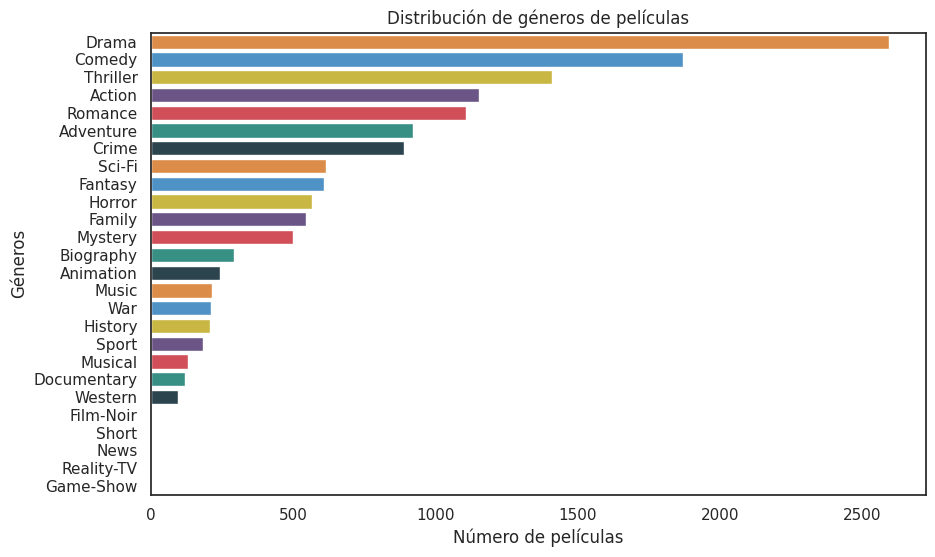

In [9]:
#Conteo de datos por genero
genre_counts = genre_dummies.sum().sort_values(ascending=False)

#Graficación de la información adquirida
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette=palette)
plt.title('Distribución de géneros de películas')
plt.xlabel('Número de películas')
plt.ylabel('Géneros')
plt.show()

## User Rating Distribution

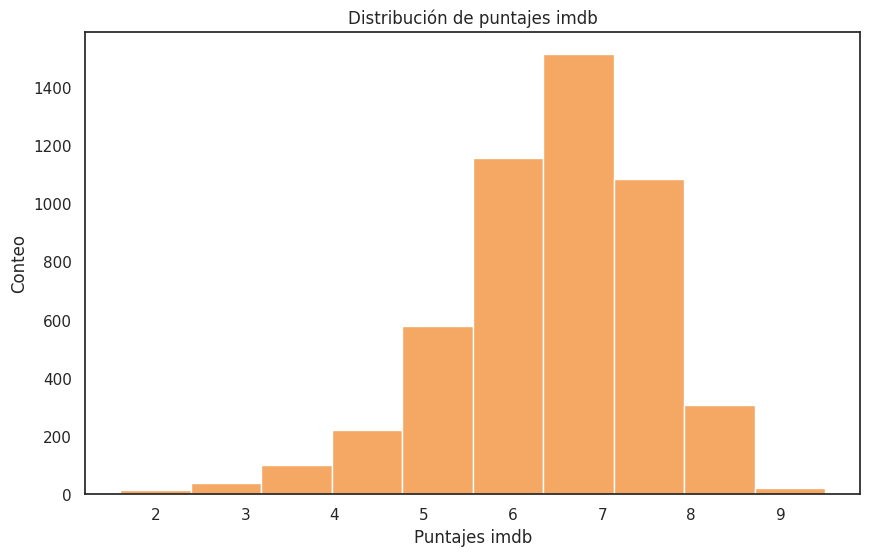

In [10]:
#Gráfico de la distribución de valoraciones imdb
plt.figure(figsize=(10, 6))
sns.histplot(relevant_data['imdb_score'], bins=10, kde=False, color=palette[0])
plt.title('Distribución de puntajes imdb')
plt.xlabel('Puntajes imdb')
plt.ylabel('Conteo')
plt.show()

## Mapa de correlación entre las variables seleccionadas




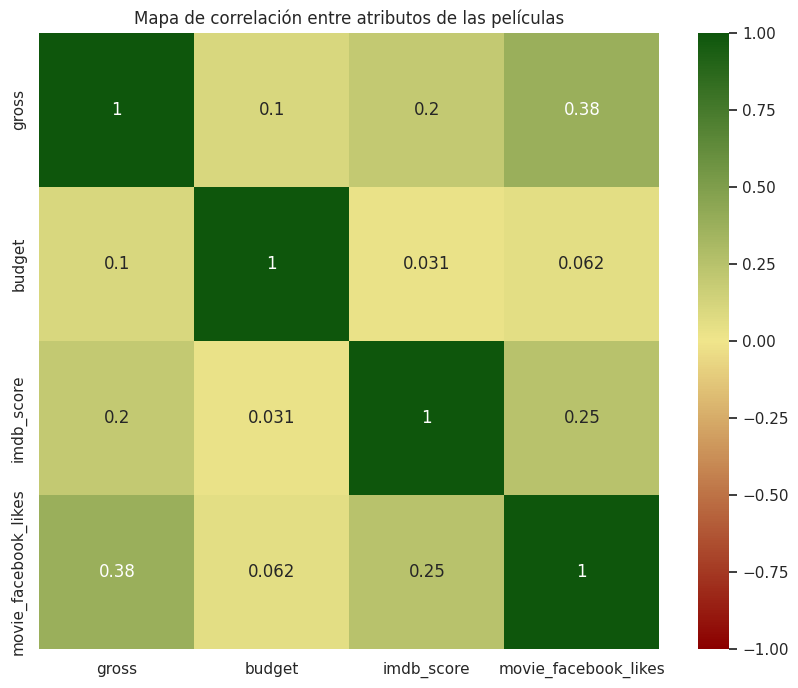

In [11]:
# Formateo de la información del mata de correlación
colors = ['#8B0000', '#f0e68c', '#0e560c']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

#Matriz de correlación entre las variables numéricas
numeric_features = ['gross', 'budget', 'imdb_score', 'movie_facebook_likes']
correlation_matrix = relevant_data[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.title('Mapa de correlación entre atributos de las películas')
plt.show()

<ipython-input-12-11ecacfe68cb>:5: UserWarning: 
The palette list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='imdb_score', y='movie_title', data=relevant_data[relevant_data['movie_title'].isin(top_rated_movies)], palette=palette)


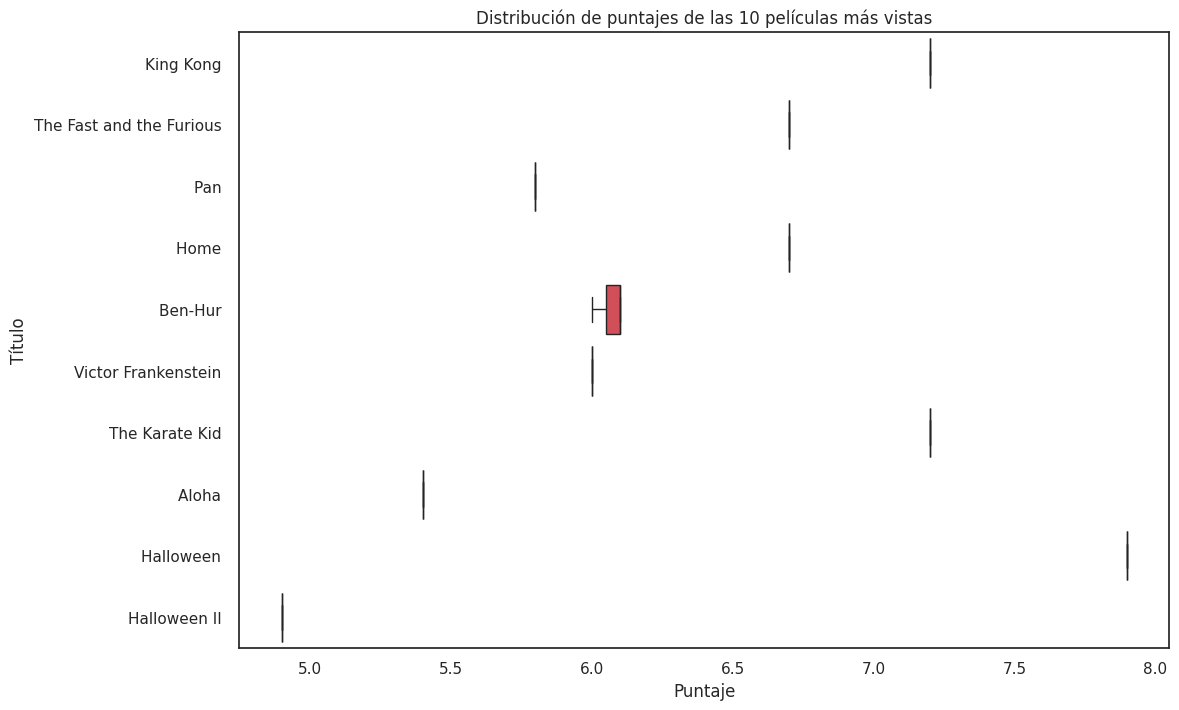

In [12]:
#Conteo de las películas
top_rated_movies = relevant_data['movie_title'].value_counts().index[:10]

plt.figure(figsize=(12, 8))
sns.boxplot(x='imdb_score', y='movie_title', data=relevant_data[relevant_data['movie_title'].isin(top_rated_movies)], palette=palette)
plt.title('Distribución de puntajes de las 10 películas más vistas')
plt.xlabel('Puntaje')
plt.ylabel('Título')
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 5. Prepare Data for the Model </b></div>

- **Step 10: Preprocessing for Model Input**. We will ensure that userId and movieId are properly formatted as integers. The ratings are also normalized to a scale of 0-1, which helps with model convergence during training.

- **Step 11: Splitting the Data**. The dataset is split into training and testing sets (80% for training and 20% for testing). This allows us to train the model on one portion of the data and evaluate its performance on unseen data.

In [13]:
# Normalizar los puntajes entre 0 y 1 para facilitar el entrenamiento (Escala original entre 1 y 10)
relevant_data['imdb_score'] = relevant_data['imdb_score'] / relevant_data['imdb_score'].max()

# División de los datos en entrenamiento y prueba (Entrenamiento 80% y prueba 20%)
train, test = train_test_split(relevant_data, test_size=0.2, random_state=42)

# Preparar imdb_score para las salidas del entrenamiento
train_ratings = train['imdb_score'].values

test_ratings = test['imdb_score'].values



# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 6. Build the Neural Network Model </b></div>

- **Step 12: Building the Recommendation Model**. We will use a neural network-based approach for this recommendation system. The key features of this model include:

    - **Embedding Layers**: Both users and movies are represented by embedding vectors. These embeddings capture latent relationships between users and movies.

    - **Concatenation**: The user and movie embeddings are concatenated and passed through dense layers to predict the user’s rating for a movie.

- **Step 13: Adding Dense Layers**.

    - After concatenating the user and movie embeddings, let's add two dense (fully connected) layers. These layers model the interaction between users and movies.

    - Activation Functions: We will use the ReLU (Rectified Linear Unit) activation function for the hidden layers, which helps the model learn non-linear relationships.

- **Step 14: Compiling the Model**. Let's compile the model using Mean Squared Error (MSE) as the loss function, which is appropriate for a regression task like predicting ratings. The optimizer used is Adam, a popular choice for deep learning models due to its efficiency.

In [ ]:
# Define input layers for user IDs and movie IDs
user_input = layers.Input(shape=(1,), name='user_input')
movie_input = layers.Input(shape=(1,), name='movie_input')

# Embedding layers for users and movies
# These embeddings learn a fixed-length representation for users and movies
user_embedding = layers.Embedding(input_dim=num_users, output_dim=50)(user_input)
user_embedding = layers.Flatten()(user_embedding)

movie_embedding = layers.Embedding(input_dim=num_movies, output_dim=50)(movie_input)
movie_embedding = layers.Flatten()(movie_embedding)

# Concatenate the user and movie embeddings
concatenated = layers.Concatenate()([user_embedding, movie_embedding])

# Add dense layers (fully connected layers) to model interactions between user and movie features
dense_1 = layers.Dense(128, activation='relu')(concatenated)
dense_2 = layers.Dense(64, activation='relu')(dense_1)

# Output layer: predicting the rating as a single value (regression task)
output = layers.Dense(1)(dense_2)

# Build the model and compile it with Mean Squared Error (MSE) loss function for regression
model = models.Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Print a summary of the model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │     33,600 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │  8,035,950 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,090,799 (30.86 MB)

 Trainable params: 8,090,799 (30.86 MB)

 Non-trainable params: 0 (0.00 B)

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 7. Training and Evaluating the Model </b></div>

In [ ]:
# Train the model using the training data, and validate it on the test data
history = model.fit(
    [train_user_ids, train_movie_ids],  # Input: user and movie IDs
    train_ratings,                      # Target: ratings
    epochs=5,
    batch_size=32,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    verbose=1                           # Show training progress
)

# Evaluate the model's performance on the test data using Mean Squared Error (MSE)
mse = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f'Test MSE: {mse}')

Epoch 1/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - loss: 0.0652 - val_loss: 0.0353
Epoch 2/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - loss: 0.0296 - val_loss: 0.0328
Epoch 3/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - loss: 0.0258 - val_loss: 0.0325
Epoch 4/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - loss: 0.0211 - val_loss: 0.0346
Epoch 5/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - loss: 0.0169 - val_loss: 0.0363
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0365
Test MSE: 0.03627840057015419


# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 8. Advanced Model with Dropout </b></div>

- **Step 15 (optional): Enhancing the Model**. To enhance the model’s robustness and prevent overfitting, we will introduce dropout regularization. Dropout randomly drops units in the neural network during training, forcing the model to generalize better.

In [ ]:
# Add dropout layers to prevent overfitting and help the model generalize better
user_input = layers.Input(shape=(1,), name='user_input')
movie_input = layers.Input(shape=(1,), name='movie_input')

# Embedding layers for users and movies
user_embedding = layers.Embedding(input_dim=num_users, output_dim=50)(user_input)
user_embedding = layers.Flatten()(user_embedding)

movie_embedding = layers.Embedding(input_dim=num_movies, output_dim=50)(movie_input)
movie_embedding = layers.Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = layers.Concatenate()([user_embedding, movie_embedding])

# Add dense layers with dropout
dense_1 = layers.Dense(128, activation='relu')(concat)
dense_1 = layers.Dropout(0.2)(dense_1)  # 20% dropout for regularization

dense_2 = layers.Dense(64, activation='relu')(dense_1)
dense_2 = layers.Dropout(0.2)(dense_2)

# Output layer for rating prediction
output = layers.Dense(1)(dense_2)

# Compile the advanced model with MSE loss
model = models.Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │     33,600 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │  8,035,950 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,090,799 (30.86 MB)

 Trainable params: 8,090,799 (30.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the advanced model
history = model.fit(
    [train_user_ids, train_movie_ids],
    train_ratings,
    epochs=5,
    batch_size=32,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    verbose=1
)

# Evaluate the advanced model
mse = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f'Test MSE: {mse}')

Epoch 1/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - loss: 0.0742 - val_loss: 0.0337
Epoch 2/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - loss: 0.0342 - val_loss: 0.0319
Epoch 3/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - loss: 0.0310 - val_loss: 0.0324
Epoch 4/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - loss: 0.0279 - val_loss: 0.0323
Epoch 5/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - loss: 0.0242 - val_loss: 0.0335
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0343
Test MSE: 0.03346678987145424


# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 9. Generation of Movie Recommendations </b></div>

## 9.1. Extract User's History

We will extract all the movie IDs that a specific user has rated:

In [ ]:
user_id = 3  # You can replace it with different user ID
rated_movies = merged_data[merged_data['userId'] == user_id][['movieId', 'rating', 'title']]

## 9.2. Generate Predictions for All Unseen Movies

Now, predict the ratings for all movies that the user has not rated yet:

In [ ]:
# Get all unique movie IDs
all_movie_ids = merged_data['movieId'].unique()

# Find movies the user hasn't rated
unseen_movie_ids = np.setdiff1d(all_movie_ids, rated_movies['movieId'])

# Create arrays for unseen movie IDs and corresponding user ID
unseen_movie_ids_input = np.array(unseen_movie_ids)
user_input_array = np.full(len(unseen_movie_ids_input), user_id)

# Predict ratings for unseen movies
predicted_ratings = model.predict([user_input_array, unseen_movie_ids_input])

# Combine unseen movie IDs with predicted ratings
movie_predictions = pd.DataFrame({
    'movieId': unseen_movie_ids_input,
    'predicted_rating': predicted_ratings.flatten()
})

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## 9.3. Sort by Predicted Ratings
Once we have the predicted ratings, we'll sort them to get the top-rated movies:

In [ ]:
# Sort by predicted rating in descending order and take the top recommendations
top_movie_recommendations = movie_predictions.sort_values(by='predicted_rating', ascending=False).head(10)

# Merge the recommendations with movie titles for easier readability
top_movie_recommendations = pd.merge(top_movie_recommendations, movies[['id', 'title']], left_on='movieId', right_on='id')

print("Movies the user has already rated:")
print(rated_movies)

print("\nTop recommended movies:")
print(top_movie_recommendations[['title', 'predicted_rating']])

Movies the user has already rated:
    movieId  rating                                 title
64      110     0.8                     Three Colors: Red
65      247     0.7                           The Killing
66      267     0.6                            Live Flesh
67      296     0.9    Terminator 3: Rise of the Machines
68      318     1.0              The Million Dollar Hotel
69      377     0.5             A Nightmare on Elm Street
70      527     0.6                    Once Were Warriors
71      588     0.6                           Silent Hill
72      592     0.6                      The Conversation
73      593     0.6                               Solaris
74      595     0.4                 To Kill a Mockingbird
75      778     0.8             Monsieur  Hulot's Holiday
76      866     0.6                     Finding Neverland
77     1271     0.6                                   300
78     1378     0.8                              Shortbus
79     1580     0.7                  